# Решение тестового задания по анализу каналов и динамики развития продукта

## Описание заданий и краткие выводы

**Задание 1**

Нужно произвести оценку каналов привлечения с точки зрения качества привлекаемых пользователей . Какие метрики Вы бы использовали? Какой канал привлечения следует развивать в первую очередь на ваш взгляд?

**Ответ**

1. В первую очередь стоит развивать Ch_1, если в нём ещё остался потенциал. По этому каналу самый высокий LTV и соотношение LTV:CAC. Умеренный CAC, возврат затрат в первый же месяц привлечения и стабильный Retention делают этот канал крайне полезным в масштабировании.
2. Во вторую очередь рекомендую развивать каналы Ch_2 и Ch_3. У них тоже хорошие метрики, кроме Payback period, так как у них CAC самый высокий. В остальном (LTV, Retention) они мало чем уступают Ch_1.
3. Не рекомендую масштабировать Ch_5, но при этом по нему можно провести пару исследований. Одно — по крупным клиентам, которые долго остаются и много платят. Второе — по причине такой высокой вовлечённости в первые месяцы и последующем резком сильном оттоке.
4. Канал Ch_4 стоит развивать в последнюю очередь. Так как он всё ещё окупается, то совсем закрывать его не стоит. Можно урезать бюджет и/или пытаться поэкспериментировать с ним.

**Задание 2**

На основании приложенных данных, оцените общую динамику развития продукта.

**Ответ**

Продукт стабильно растёт и по пользователям, и по деньгам. Его уже можно масштабировать, и желательно сделать упор на каналы Ch_1, Ch_2, Ch_3.

1. Стабильный Retention и отток пока что даёт возможность растить MAU даже со стабильным привлечением.
2. Вместе с MAU линейно растёт Revenue и Cash Flow.
3. Абсолютно все когорты и каналы окупаются.
4. Развитие каналов Ch_1, Ch_2, Ch_3 позволит улучшить общий Retention, повысит Cash Flow в абсолютных числах и увеличит ROMI.

## Данные

Файлы с данными по продукту (data_app.csv) и стоимость привлечения по каналам одного юзера (ch_cost.csv).

Файл `data_app.csv`.

- `Fst_mnth` – месяц, в котором пользователи впервые пришли в приложение (когорта пользователей);
- `Business_mnth` – отчетный месяц;
- `Au` — активная аудитория приложения (уникальные пользователи) в отчетном месяце;
- `Channel` — канал привлечения;
- `Rev` — выручка в отчетном месяце по когорте пользователей.

Файл `ch_cost.csv`.

- `channel` — канал привлечения;
- `cost_per_user` — стоимость привлечения одного юзера.

## Библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from dateutil import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
pd.set_option('display.max_columns', None)

%config InlineBackend.figure_format = 'svg'

## Загрузка и первичная обработка данных

In [3]:
data_app = pd.read_csv('../data_app.csv', delimiter=';', decimal=',')
ch_costs = pd.read_csv('../ch_cost.csv', delimiter=';')

data_app['fst_mnth'] = pd.to_datetime(data_app['fst_mnth'], dayfirst=True)
data_app['business_mnth'] = pd.to_datetime(data_app['business_mnth'], dayfirst=True)

Сразу соединим датафреймы:

In [4]:
df = pd.merge(left=data_app, right=ch_costs, on='channel')
df.sort_values(by=['fst_mnth', 'channel', 'business_mnth'], inplace=True)

# находим номер отчётного месяца с момента привлечения
df['n_month'] = df.apply(
    lambda x: relativedelta.relativedelta(x['business_mnth'], x['fst_mnth']).months,
    axis=1
    )

Теперь определим метрики для когорт (размер, потраченный маркетинговый бюджет):

In [5]:
cohorts_data = df[df['n_month'] == 0][['fst_mnth', 'channel', 'au', 'cost_per_user', 'rev']].copy()
cohorts_data.rename(columns={'au': 'cohort_size', 'rev': 'rev_1_month'}, inplace=True)
cohorts_data['marketing_budget'] = cohorts_data['cohort_size'] * cohorts_data['cost_per_user']

df = pd.merge(left=df, right=cohorts_data[['fst_mnth', 'channel', 'cohort_size', 'marketing_budget', 'rev_1_month']], on=['fst_mnth', 'channel'])

Теперь, когда у нас данные по первому месяцу когорт, мы можем рассчитать метрики для анализа:

In [6]:
# cumulative revenue and margin
df['rev_cum'] = df.groupby(['fst_mnth', 'channel'])['rev'].cumsum()
df['margin'] = df['rev_cum'] - df['marketing_budget']
df[['rev_prev', 'au_prev', 'margin_prev']] = df.groupby(['fst_mnth', 'channel'])[['rev', 'au', 'margin']].shift(1)

def calculate_metrics(df):
    metrics = df.copy()
    
    metrics['arpu'] = metrics['rev'] / metrics['au']
    metrics['ltv'] = metrics['rev_cum'] / metrics['cohort_size'] #ltv n-month
    metrics['retention'] = metrics['au'] / df['cohort_size']

    # churn аудитории и revenue
    metrics['revenue_churn'] = (metrics['rev_prev'] - metrics['rev']) / metrics['rev_prev']
    metrics['churn'] = (metrics['au_prev'] - metrics['au']) / metrics['au_prev']

    # метрика по окупаемости маркетинговых затрат
    metrics['romi'] = (metrics['rev_cum'] - metrics['marketing_budget']) / metrics['marketing_budget']
    metrics['ltv_cac'] = metrics['ltv'] / metrics['cost_per_user']

    # мультпликатор revenue
    metrics['rev_coefficient'] = metrics['rev_cum'] / metrics['rev_1_month']
    
    return metrics

df = calculate_metrics(df)

Следующее, что нам понадобится для анализа — [CCAC payback period](https://www.stage2.capital/blog/ltvcac-is-a-misleading-metric-to-measure-performance-heres-what-to-track-instead). Эта метрика показывает, насколько быстро окупается маркетинговый бюджет и когда его можно снова реинвестировать в привлечение.

In [7]:
def calculate_payback_period(df):
    payback_month = (
        ((df['margin_prev'] < 0) & (df['margin'] >= 0)) | ((df['n_month'] == 0) & (df['margin'] >= 0))
    )

    return payback_month.astype(int)

df['is_payback'] = calculate_payback_period(df)

## Задание 1. Оценка каналов

Для оценки качества пользователей посмотрим на следующие метрики тотал, в динамике и по когортам:

- ARPU;
- LTV n-month — для понимания, сколько примерно денег приносит пользователь на n месяц;
- LTV/CAC — окупается ли привлечение и насколько больше приносит денег;
- CCAC Payback Period — насколько быстро окупается привлечение;
- Retention — какая доля аудитории осталась активной по сравнению с месяцем привлечения.

Прежде всего сделаем общую сводку по каналам:

In [8]:
channels_total = df \
    .groupby(['channel', 'n_month', 'cost_per_user']) \
        [['cohort_size',
        'au',
        'au_prev',
        'rev',
        'rev_cum',
        'rev_prev',
        'rev_1_month',
        'marketing_budget']] \
    .sum() \
    .reset_index()

channels_total = calculate_metrics(channels_total)

### LTV:CAC

Прежде всего посмотрим на соотношение LTV:CAC по периодам после регистрации. Это позволит нам увидеть, сколько продукт получает или теряет на каждой вложенной у.е.:

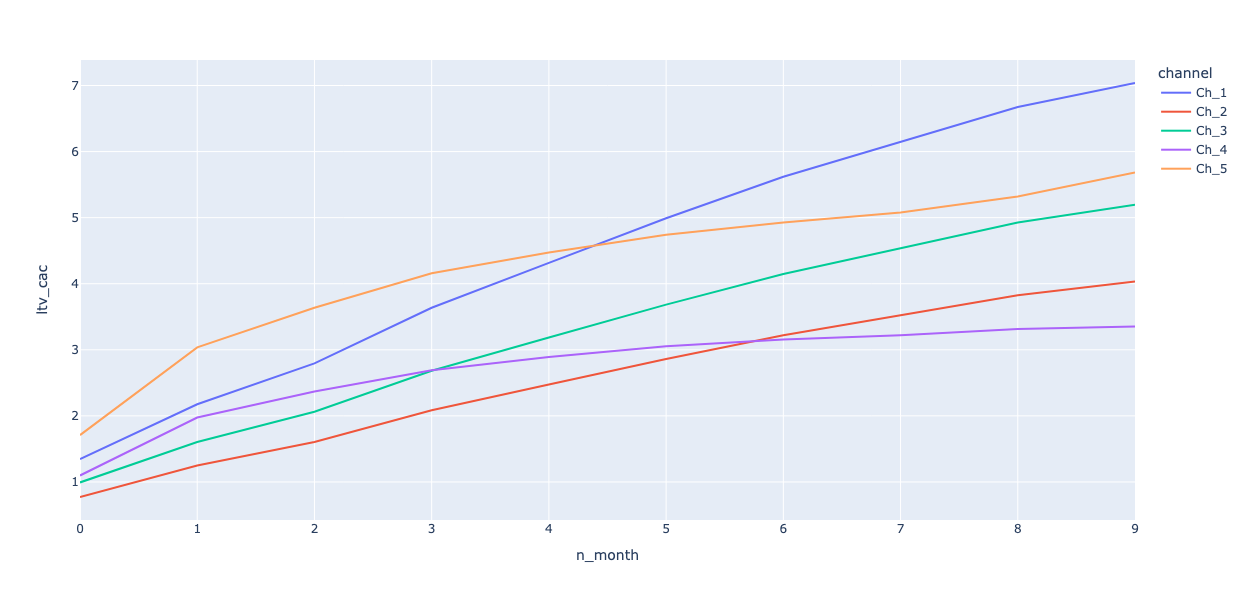

In [9]:
fig = px.line(channels_total, x="n_month", y="ltv_cac", color='channel', width=1000, height=600)
fig.show()

In [10]:
channels_total.groupby(['channel'])['ltv_cac'].max().sort_values(ascending=False)

channel
Ch_1    7.037812
Ch_5    5.681724
Ch_3    5.196351
Ch_2    4.034973
Ch_4    3.352423
Name: ltv_cac, dtype: float64

Все каналы приносят довольно много денег с каждого привлечённого юзера, и это очень хорошо. Но абсолютный топ — Ch_1.</br>
При этом каналы Ch_5 и Ch_4 имеют в первые месяцы очень хорошие значения, но со временем теряют темп. Ch_4 и вовсе почти вышел на плато. Значит, пользователи из этих каналов со временем меньше платят и база платящих клиентов быстро кончается.</br>
При этом у остальных каналов стабильный рост, а это значит, что у них хороший Retention платящих пользователей и хорошая конверсия в повторные покупки.

### LTV

Теперь посмотрим на сам LTV:

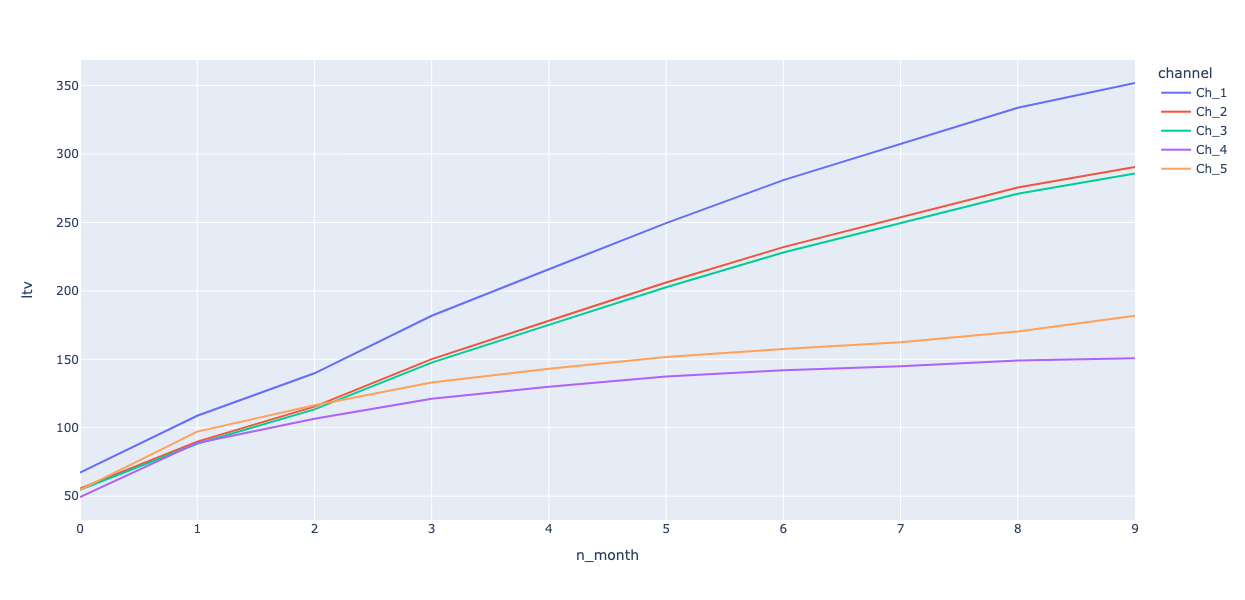

In [11]:
fig = px.line(channels_total, x="n_month", y="ltv", color='channel', width=1000, height=600)
fig.show()

In [12]:
channels_total.groupby(['channel'])[['cost_per_user', 'ltv']].max().sort_values(by='ltv', ascending=False)

cost_per_user         ltv
channel                           
Ch_1                50  351.890588
Ch_2                72  290.518070
Ch_3                55  285.799278
Ch_5                32  181.815167
Ch_4                45  150.859026

Видно, что LTV со временем растёт по всем каналам, кроме 4 и 5, которые выходят на плато. Этот тренд полностью повторяет тренд LTV:CAC.</br>
Тут победитель снова Ch_5. С большим отрывом в 21% (или 61,4 у.е.) он опережает идущие почти наравне Ch_2 и Ch_3.</br>
И если с Ch_5 не всё так однозначно из-за высокого LTV:CAC, то худший канал однозначно снова Ch_4.

Когортный анализ LTV по каждому отдельному каналу ничего не показал — когорты практически не отличаются внутри отдельного канала.</br>
Только по Ch_5 заметно, что у самой первой когорты LTV по всем периодам выше:

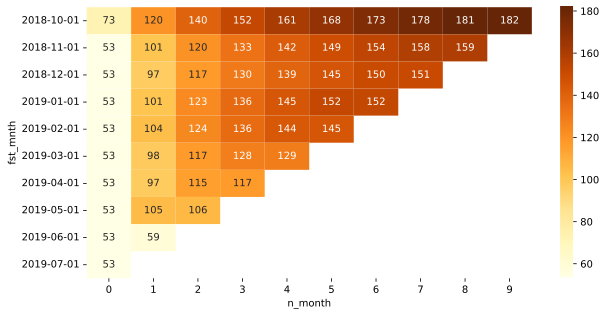

In [13]:
plt.figure(figsize=(10,5))

ax = sns.heatmap(
    df[df['channel'] == 'Ch_5'].pivot_table(index='fst_mnth', columns='n_month', values='ltv'),
    annot=True,
    fmt=".0f",
    cmap='YlOrBr')

yticks = ax.get_yticks()
yticklabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m-%d') for x in ax.get_yticklabels()]

_ = ax.set_yticks(yticks, yticklabels, rotation=0)

plt.show()

### CCAC Payback Period

In [14]:
df[df['is_payback'] == 1].groupby('channel')['n_month'].mean().sort_values()

channel
Ch_1    0.0
Ch_4    0.0
Ch_5    0.0
Ch_2    1.0
Ch_3    1.0
Name: n_month, dtype: float64

Каналы 1, 4 и 5 окупаются в месяц привлечения, в то время как 2 и 3 — лишь месяц спустя.

Проверим, есть ли динамика по этому показателю:

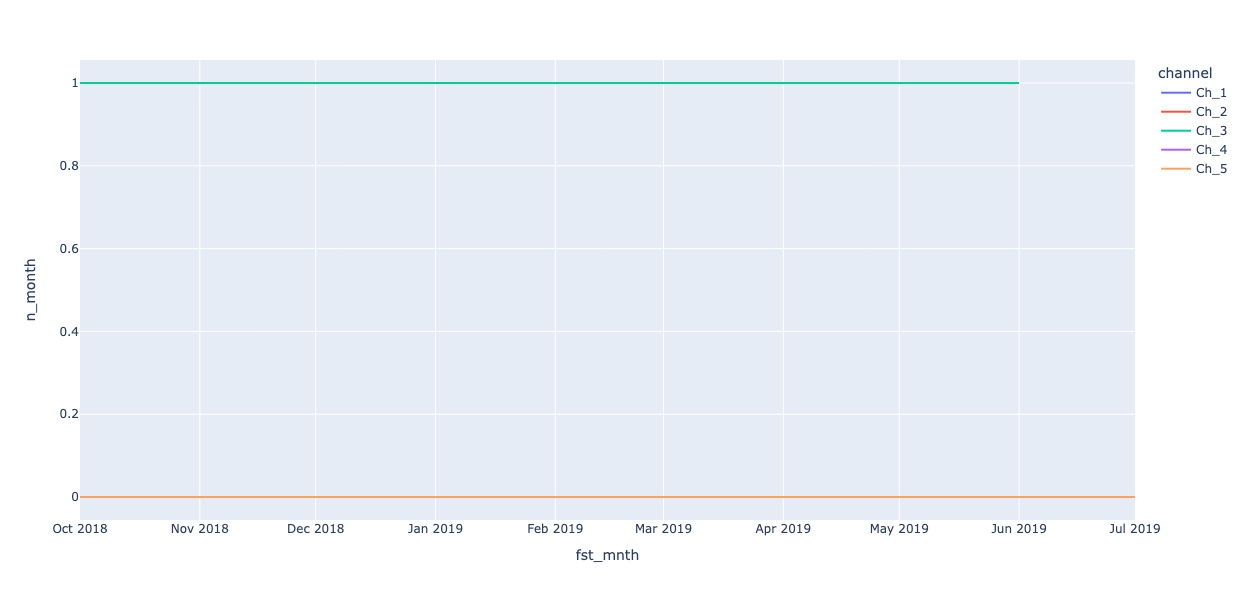

In [15]:
fig = px.line(df[df['is_payback'] == 1], x="fst_mnth", y="n_month", color='channel', width=1000, height=600)
fig.show()

Нет, Payback period оказался полностью статичен.

### Retention

Здесь мы будем смотреть на Retention N-month:

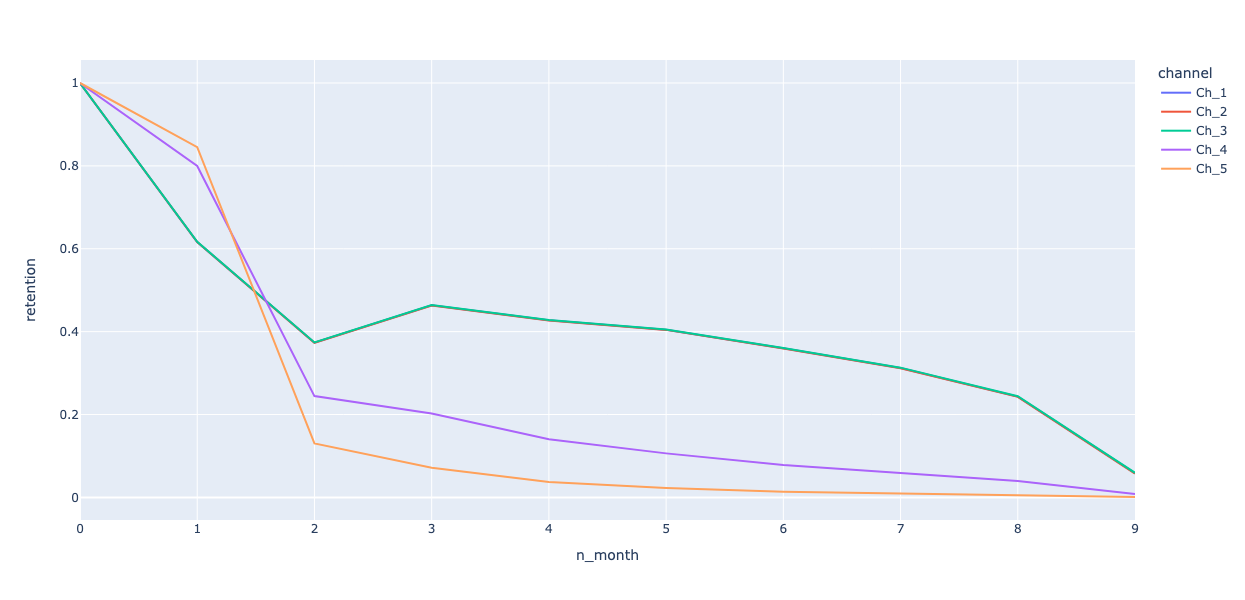

In [16]:
fig = px.line(channels_total, x="n_month", y="retention", color='channel', width=1000, height=600)
fig.show()

Ch_4 и Ch_5 показали тут себя хуже всего.</br>
Пользователи из Ch_1, Ch_2 и Ch_3 ведут себя совершенно одинаково: после просадки в 2-м месяце есть рост в 3-м и дальше плавное снижение.</br>
В то время как падение Ch_4 и Ch_5 к 2-му месяцу гораздо более сильное, после которого они уже не восстанавливаются.

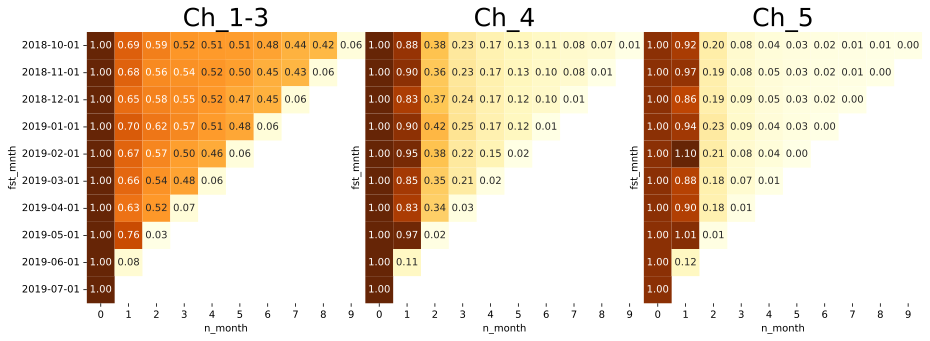

In [17]:
plt.rcParams["figure.figsize"] = [15, 5]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(
    df[df['channel'] == 'Ch_3'].pivot_table(index='fst_mnth', columns='n_month', values='retention'),
    annot=True,
    fmt=".2f",
    cmap='YlOrBr',
    ax=ax1,
    cbar=False)

sns.heatmap(
    df[df['channel'] == 'Ch_4'].pivot_table(index='fst_mnth', columns='n_month', values='retention'),
    annot=True,
    fmt=".2f",
    cmap='YlOrBr',
    ax=ax2,
    cbar=False,
    yticklabels=False)

sns.heatmap(
    df[df['channel'] == 'Ch_5'].pivot_table(index='fst_mnth', columns='n_month', values='retention'),
    annot=True,
    fmt=".2f",
    cmap='YlOrBr',
    ax=ax3,
    cbar=False,
    yticklabels=False)

yticks = ax1.get_yticks()
yticklabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m-%d') for x in ax1.get_yticklabels()]

_ = ax1.set_yticks(yticks, yticklabels, rotation=0)

ax1.set_title('Ch_1-3', fontdict={'fontsize': 25, 'verticalalignment': 'center'})
ax2.set_title('Ch_4', fontdict={'fontsize': 25, 'verticalalignment': 'center'})
ax3.set_title('Ch_5', fontdict={'fontsize': 25, 'verticalalignment': 'center'})

fig.subplots_adjust(wspace=0.001)
plt.show()

Когортный анализ показал то же самое. Когорты между собой мало отличаются, то есть в динамике изменений нет.</br>
Интересно, что по Ch_4 и Ch_5 Retention 1 месяца гораздо выше, чем по другим каналам. При этом падение на 2 месяц достигает 50-70 п.п. Это выглядит как возможная точка роста.</br>
Также странно, что у февральской и майской когорты Ch_5 активная аудитория на следующий месяц после регистрации больше, чем в сам месяц регистрации. Это может быть либо ошибка в данных, либо когорты определяются не по регистрации/активации, а по другому признаку (например, по попаданию в маркетинговую кампанию).

### ARPU

Проверим, есть ли динамика по ARPU.

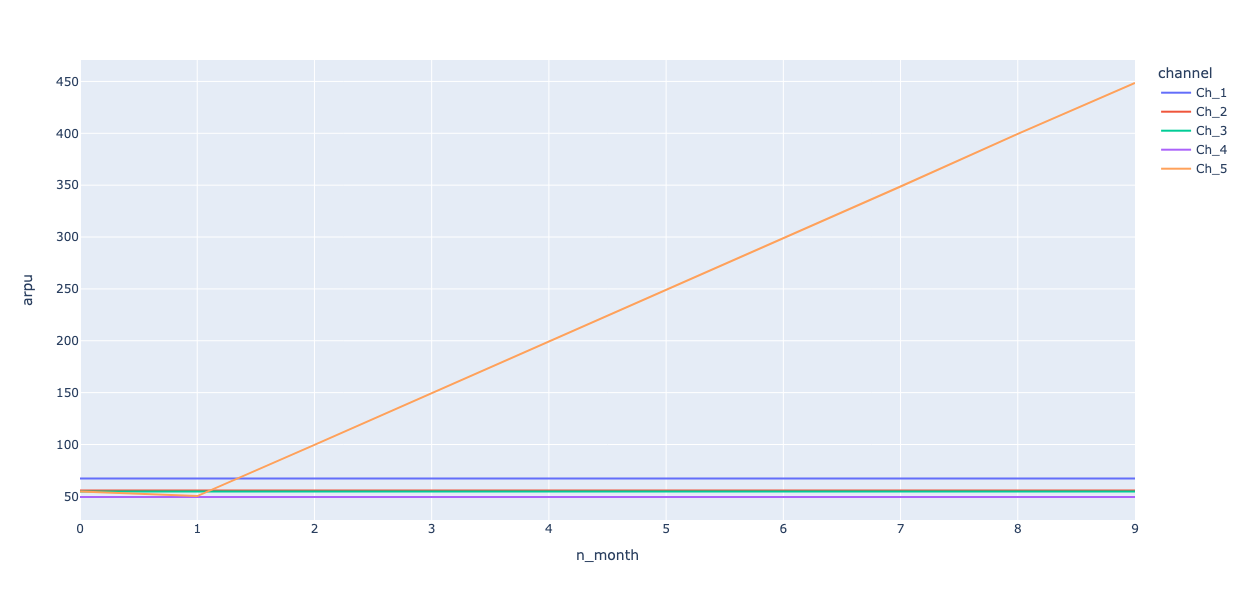

In [18]:
fig = px.line(channels_total, x="n_month", y="arpu", color='channel', width=1000, height=600)
fig.show()

ARPU растёт только по Ch_5. С помощью когортного анализа проверим, это влияние одной когорты и у всех когорт такое поведение:

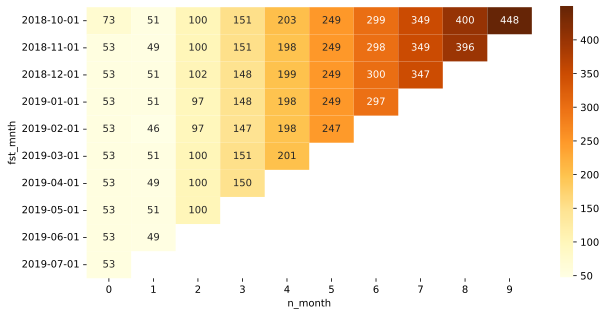

In [19]:
plt.figure(figsize=(10,5))

ax = sns.heatmap(
    df[df['channel'] == 'Ch_5'].pivot_table(index='fst_mnth', columns='n_month', values='arpu'),
    annot=True,
    fmt=".0f",
    cmap='YlOrBr')

yticks = ax.get_yticks()
yticklabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m-%d') for x in ax.get_yticklabels()]

_ = ax.set_yticks(yticks, yticklabels, rotation=0)

plt.show()

Оказывается, что это типично для всех когорт. ARPU к последним месяцам вырастает почти до 6-7 раз!</br>
Если учитывать данные по Retention, то скорее всего из когорт остаются только самые замотивированные пользователи, которые тратят больше всего. Именно за счёт них и низкого CAC (он самый низкий для Ch_5) этот канал вырываться на 2 место по соотношение LTV к CAC.

**Рекомендация:**</br>
Рекомендую более подробно исследовать таких клиентов. Возможно, это новый сегмент или новая аудитория, для которой стоит сделать отдельные рекламные кампании.

### Выводы

1. В первую очередь стоит развивать Ch_1, если в нём ещё остался потенциал. По этому каналу самый высокий LTV и соотношение LTV:CAC. Умеренный CAC, возврат затрат в первый же месяц привлечения и стабильный Retention делают этот канал крайне полезным в масштабировании.
2. Во вторую очередь рекомендую развивать каналы Ch_2 и Ch_3. У них тоже хорошие метрики, кроме Payback period, так как у них CAC самый высокий. В остальном (LTV, Retention) они мало чем уступают Ch_1.
3. Не рекомендую масштабировать Ch_5, но при этом по нему можно провести пару исследований. Одно — по крупным клиентам, которые долго остаются и много платят. Второе — по причине такой высокой вовлечённости в первые месяцы и последующем резком сильном оттоке.
4. Канал Ch_4 стоит развивать в последнюю очередь. Так как он всё ещё окупается, то совсем закрывать его не стоит. Можно урезать бюджет и/или пытаться поэкспериментировать с ним.

## Задание 2: Оценка общей динамики развития продукта

Здесь я буду смотреть на следующие метрики:

- Привлечение новых пользователей;
- Отток пользователей;
- MAU;
- Retention;
- Cash Flow;
- ROMI.

### MAU

In [20]:
users = df.assign(
        new = np.where(df['n_month'] == 0, df['au'], 0),
        old = np.where(df['n_month'] != 0, df['au'], 0),
        total = df['au']
    ) \
    .groupby('business_mnth') \
    .agg({'new':sum, 'old':sum, 'total':sum}) \
    .reset_index()

mau = users.melt(
    id_vars=['business_mnth'],
    value_name='mau',
    var_name='user_type'
)

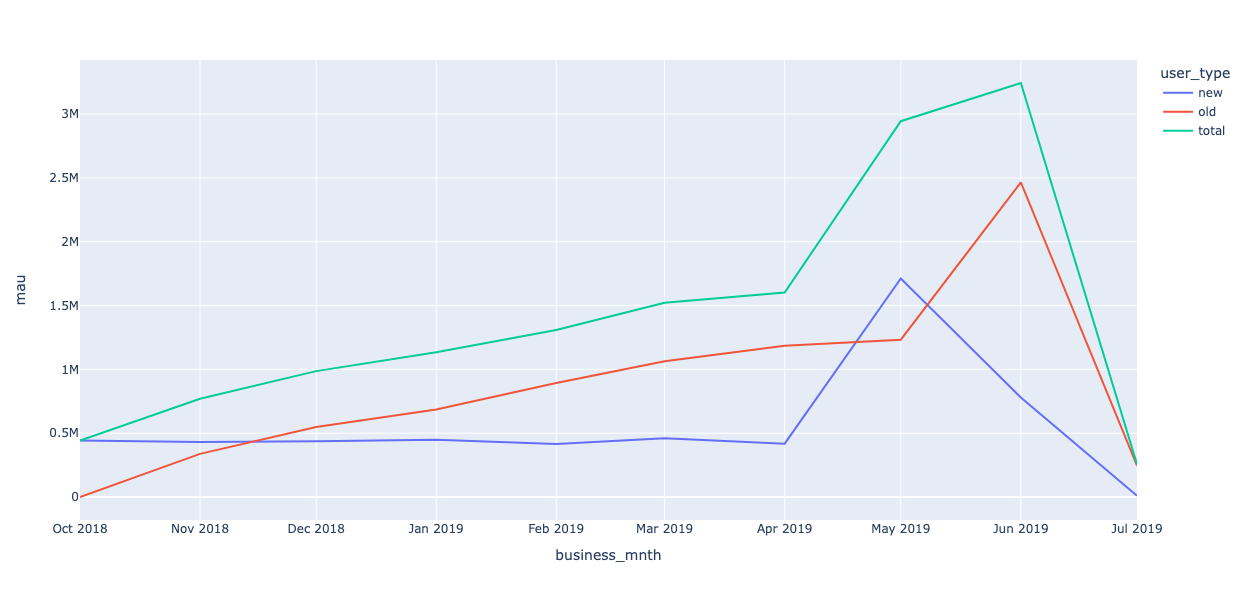

In [21]:
fig = px.line(mau, x="business_mnth", y="mau", color='user_type', width=1000, height=600)
fig.show()

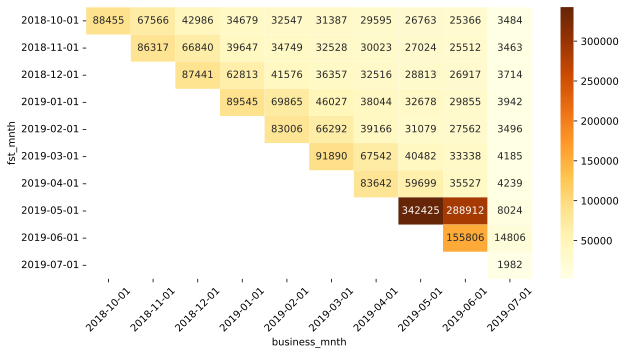

In [22]:
users_pivot = df.pivot_table(index='fst_mnth', columns='business_mnth', values='au')

plt.figure(figsize=(10,5))

ax = sns.heatmap(
    users_pivot,
    annot=True,
    fmt=".0f",
    cmap='YlOrBr'
    )

xticks = ax.get_xticks()
xticklabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m-%d') for x in ax.get_xticklabels()]

_ = ax.set_xticks(xticks, xticklabels, rotation=45)

yticks = ax.get_yticks()
yticklabels = [pd.to_datetime(x.get_text()).strftime('%Y-%m-%d') for x in ax.get_yticklabels()]

_ = ax.set_yticks(yticks, yticklabels, rotation=0)

plt.show()

Как видно по графику и когортам выше, продукт стабильно набирал аудиторию. Отток старых пользователей был довольно плавным и позволял итоговому MAU расти с каждым месяцем.</br>
В мае 2019 был резкий скачок новых пользователей, который сразу поднял MAU на 84%. При этом большая часть пришедшей аудитории осталась, что позволило в июне уже удвоить MAU по сравнению с апрелем.

Скорее всего за июль 2019 данные не полные, так как провал идёт по всем когортам.

### Revenue, Cash Flow и ROMI

In [23]:
revenue_costs = df.assign(
        marketing_budget = np.where(df['n_month'] == 0, df['marketing_budget'], 0),
        rev = df['rev']
    ) \
    .groupby('business_mnth') \
    .agg({'marketing_budget':sum, 'rev':sum}) \
    .reset_index()

revenue_costs['cash_flow'] = revenue_costs['rev'] - revenue_costs['marketing_budget']
revenue_costs['cash_flow_cum'] = revenue_costs['cash_flow'].cumsum()

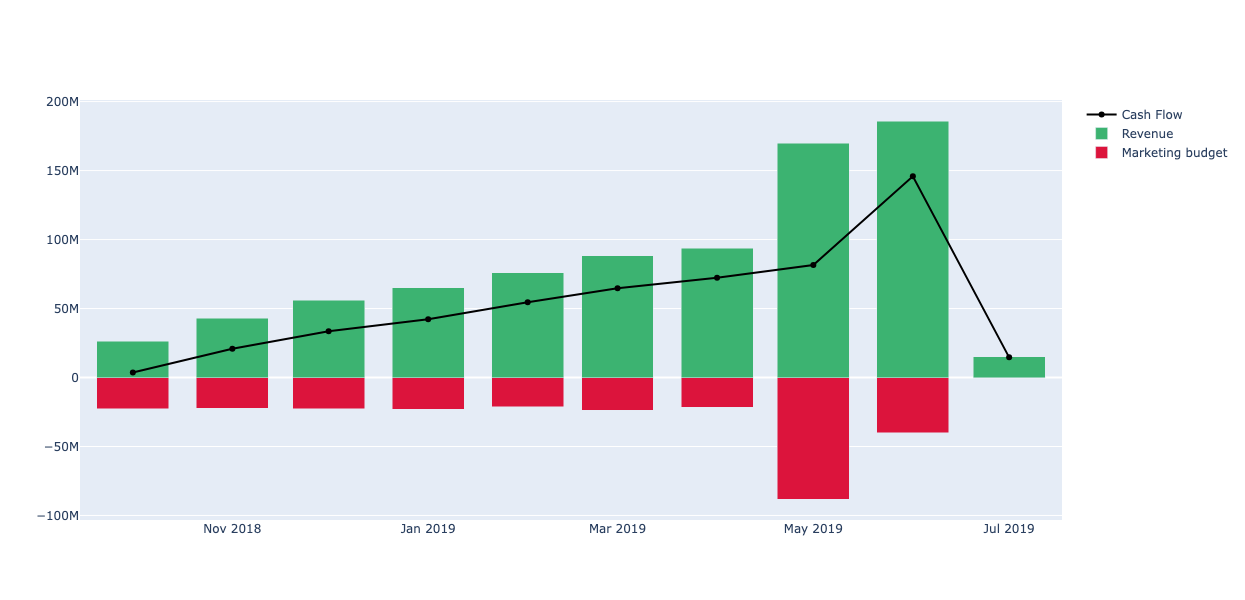

In [25]:
business_mnths = revenue_costs['business_mnth'].values
marketing_budgets = revenue_costs['marketing_budget'].values
revenue = revenue_costs['rev'].values
cash_flow = revenue_costs['cash_flow'].values

fig = go.Figure(layout={'width':1000, 'height': 600, 'barmode': 'stack'})

fig.add_trace(go.Bar(
                x=business_mnths,
                y=marketing_budgets*-1,
                base=0,
                marker_color='crimson',
                name='Marketing budget')
             )

fig.add_trace(go.Bar(
                x=business_mnths,
                y=revenue,
                base=0,
                marker_color='mediumseagreen',
                name='Revenue')
             )

fig.add_trace(go.Line(
                x=business_mnths,
                y=cash_flow,
                marker_color='black',
                name='Cash Flow')
             )

fig.show()

С самого первого месяца Revenue было больше маркетинговых костов. К июню разница между Revenue и костами составила почти 146 млн, что в 3,65 раза больше самих костов.</br>
Есть ярко выраженная динамика Cash Flow — чем больше пользователей привлекаем, то больше денег зарабатываем. Мы знаем, что каждый отдельный канал выгоден, но посмотрим, сколько принесла денег каждая отдельная когорта:

In [26]:
monthly_total_cohort = df[df['business_mnth'] == '2019-07-01'] \
    .groupby(['fst_mnth']) \
    .agg(
        cohort_size = ('cohort_size', 'sum'),
        marketing_budget = ('marketing_budget', 'sum'),
        rev_cum = ('rev_cum', 'sum')
    ).reset_index()

monthly_total_cohort['cash_flow'] = monthly_total_cohort['rev_cum'] - monthly_total_cohort['marketing_budget']
monthly_total_cohort['romi'] = (monthly_total_cohort['rev_cum'] - monthly_total_cohort['marketing_budget']) / monthly_total_cohort['marketing_budget'] * 100

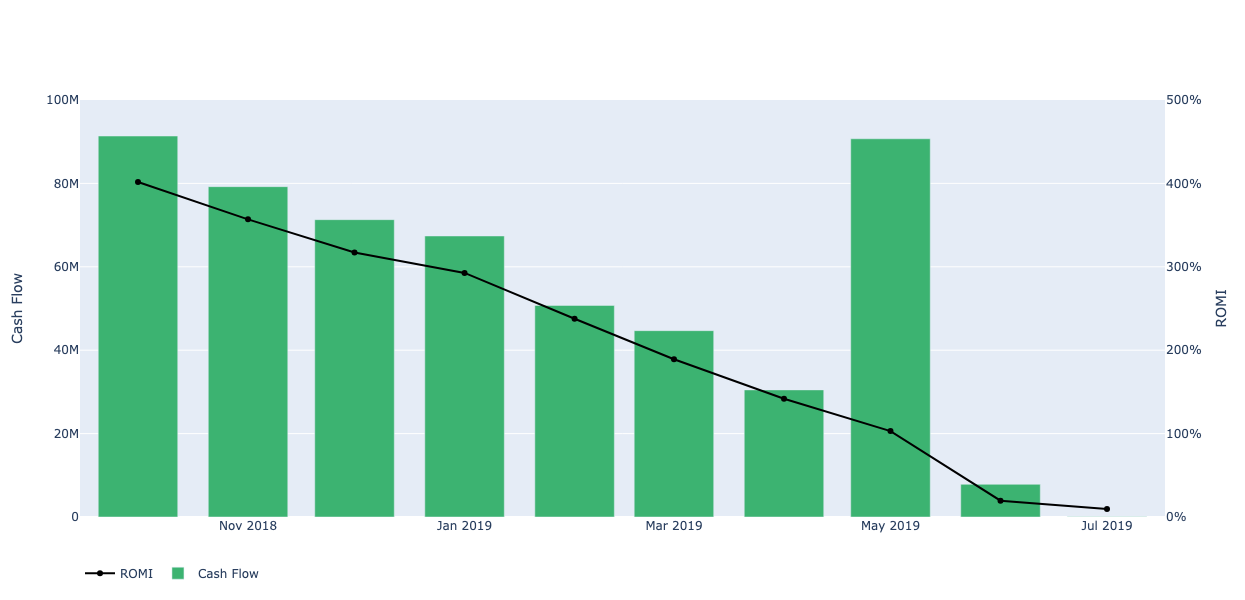

In [28]:
fst_mnth = monthly_total_cohort['fst_mnth'].values
cash_flow = monthly_total_cohort['cash_flow'].values
romi = monthly_total_cohort['romi'].values

fig = go.Figure(layout={'width':1000, 'height': 600, 'barmode': 'stack'})

fig.add_trace(go.Bar(
                x=fst_mnth,
                y=cash_flow,
                base=0,
                marker_color='mediumseagreen',
                name='Cash Flow')
             )

fig.add_trace(go.Line(
                x=business_mnths,
                y=romi,
                marker_color='black',
                name='ROMI',
                yaxis='y2')
             )

fig.update_layout(
    legend=dict(orientation="h"),
    yaxis=dict(
        title=dict(text="Cash Flow"),
        side="left",
        range=[0, 100000000],
    ),
    yaxis2=dict(
        title=dict(text="ROMI"),
        side="right",
        range=[0, 500],
        overlaying="y",
        tickmode="sync",
    ),
    yaxis2_ticksuffix = "%"
)

fig.show()

Все когорты окупились. Особенно интересен тут пик по майской когорте. Но он связан лишь с огромным приростом новых пользователей, так как ROMI остаётся в тренде.</br>
При этом июньская когорта тоже крупнее всех остальных до мая, но у её Cash Flow вписывается в общий тренд. Стоит учесть, что не у всех пользователей июньской когорты мог пройти полный календарный месяц, поэтому повторные покупки по ней ещё не успели накопиться и по ней картину нельзя считать полной.

### CPA

Проверим, есть ли изменения по стоимости привлечения пользователя:

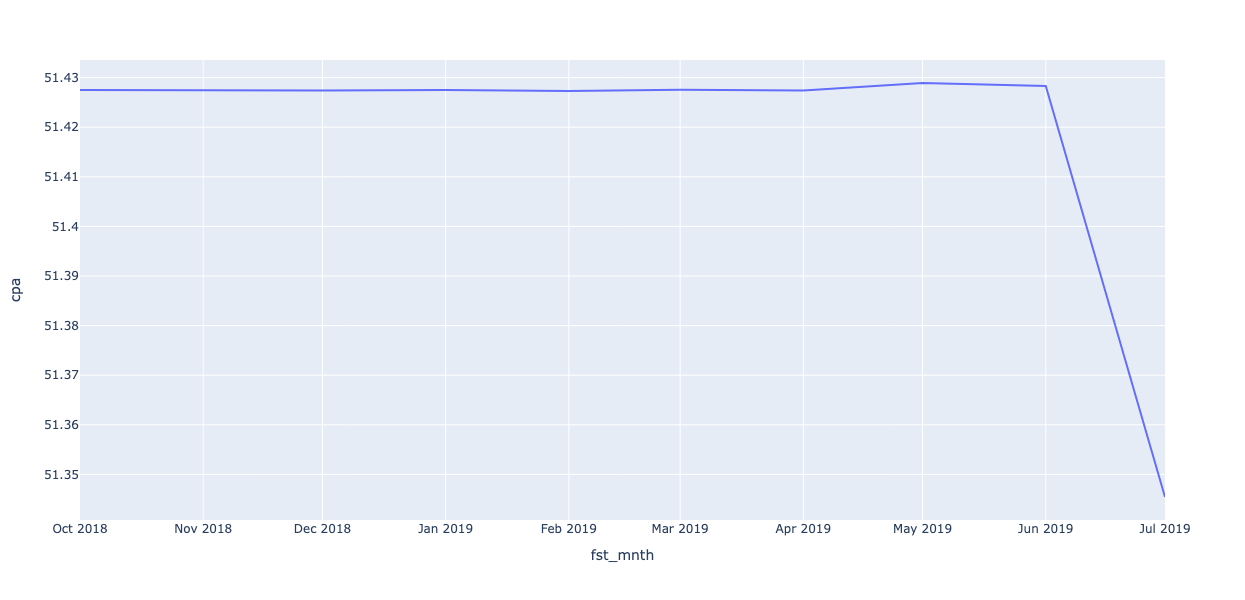

In [29]:
monthly_total_cohort['cpa'] = monthly_total_cohort['marketing_budget'] / monthly_total_cohort['cohort_size']

fig = px.line(monthly_total_cohort, x="fst_mnth", y="cpa", width=1000, height=600)
fig.show()

Так как июль 2019 явно не полный, то можем сказать, что изменений по CPA нет.

### Retention

Оценим изменения Retention по времени, если такие изменения вообще есть:

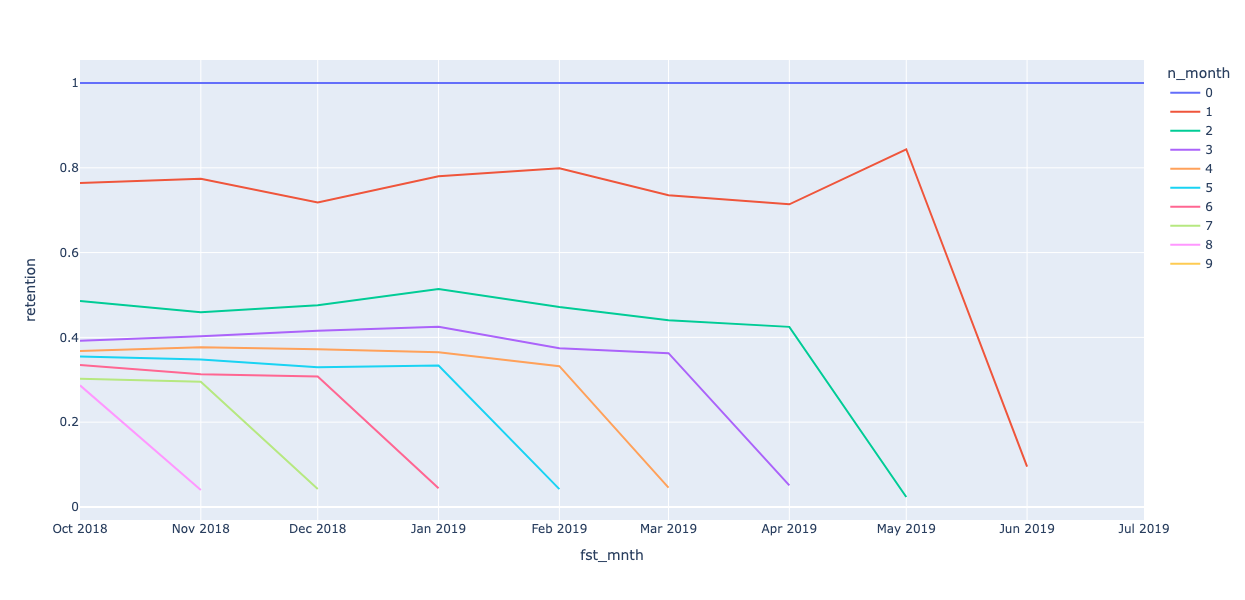

In [30]:
period_total = df \
    .groupby(['n_month', 'fst_mnth']) \
        [['cohort_size',
        'au']] \
    .sum() \
    .reset_index()

period_total['retention'] = period_total['au'] / period_total['cohort_size']

fig = px.line(period_total, x="fst_mnth", y="retention", color='n_month', width=1000, height=600)
fig.show()

У новых когорт (начиная с января 2019) есть тенденция на снижение Retention 2-3 месяца. Так как внутри каналов Retetion меняется очень слабо, то дело скорее всего в пропорциях каналов. Если сделать упор на каналы 1-3, то Retention после 2 месяца сильно поднимется.</br>
В остальном заметных изменений или провалов нет.

### Выводы

Продукт стабильно растёт и по пользователям, и по деньгам. Его уже можно масштабировать, и желательно сделать упор на каналы Ch_1, Ch_2, Ch_3.

1. Стабильный Retention и отток пока что даёт возможность растить MAU даже со стабильным привлечением.
2. Вместе с MAU линейно растёт Revenue и Cash Flow.
3. Абсолютно все когорты и каналы окупаются.
4. Развитие каналов Ch_1, Ch_2, Ch_3 позволит улучшить общий Retention, повысит Cash Flow в абсолютных числах и увеличит ROMI.